In [1]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

Projekt zaliczeniowy PSI- Piotr Kubacki Temat: Przewidywanie zawału na podstawie danych medycznych

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
# del data['id']
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
print(len(data[data.stroke==0]),len(data[data.stroke==1]))

4861 249


In [4]:
print(len(data[data.avg_glucose_level <= 114]))
print(len(data[(data.avg_glucose_level > 114) & (data.avg_glucose_level <= 140)]))
print(len(data[data.avg_glucose_level > 140]))

3828
461
821


1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Sprawdźmy unikalne wartości w kolumnach kategorycznych

In [5]:
for col in (data['gender'],data['ever_married'],data['work_type'],data['Residence_type'],data['smoking_status']):
    print(col.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [6]:
data['smoking_status'].replace('Unknown',np.nan, inplace=True)

Zwizualizujemy brakujące dane

In [7]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

,Total,Percent
smoking_status,1544,30.215264
bmi,201,3.933464


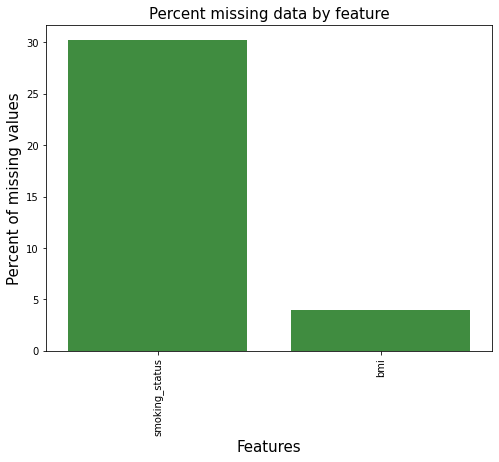

In [8]:
missingdata(data)

Trzeba coś zrobić z nanami:
* w bmi jest mało do uzupełnienia. Wrzucimy tam wartości na podstawie work_type
* smoking_status ma dużo braków, ale z uwagi na istotność kolumny uznajemy, że 30% jest akceptowalne do uzupełnienia. Za nany wrzucimy wartości z ['formerly smoked' 'never smoked' 'smokes'] na podstawie work_type

In [9]:
import numpy as np
# filldata = ['formerly smoked', 'never smoked', 'smokes']
# data['smoking_status']=data['smoking_status'].map(lambda l: l if not pd.isnull(l) else np.random.choice(filldata))
print(type(data[data['work_type']=='Private']['bmi'].mean()))
print(data[data['work_type']=='Self-employed']['bmi'].mean())
print(data[data['work_type']=='Govt_job']['bmi'].mean())
print(data[data['work_type']=='children']['bmi'].mean())
print(data[data['work_type']=='Never_worked']['bmi'].mean())

<class 'numpy.float64'>
30.211870967741937
30.522063492063495
20.038002980625933
25.545454545454547


In [10]:
def impute_bmi(cols):
    bmi = cols[0]
    work_type = cols[1]

    if pd.isnull(bmi):
        if work_type == 'Private':
            return data[data['work_type']=='Private']['bmi'].mean()
        elif work_type == 'Self-employed':
            return data[data['work_type']=='Self-employed']['bmi'].mean()
        elif work_type == 'Govt_job':
            return data[data['work_type']=='Govt_job']['bmi'].mean()
        elif work_type == 'children':
            return data[data['work_type']=='children']['bmi'].mean()
        else:
            return data[data['work_type']=='Never_worked']['bmi'].mean()
    else:
        return bmi

def impute_smoking_status(cols):
    smoking_status = cols[0]
    age = cols[1]
    imput_vals = ['smokes','never smokes']
    # na podstawie statystyk palaczy zaleznie od wieku: https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm
    if pd.isnull(smoking_status):
        if age < 15:
            return imput_vals[1]
        if 15 <= age < 25:
            return np.random.choice(imput_vals,p=[0.07,0.93])
        if 25 <= age < 45:
            return np.random.choice(imput_vals,p=[0.141,0.859])
        if 45 <= age < 65:
            return np.random.choice(imput_vals,p=[0.149,0.851])
        else:
            return np.random.choice(imput_vals,p=[0.09,0.91])
    else:
        return smoking_status

In [11]:
data['bmi'] = data[['bmi','work_type']].apply(impute_bmi,axis=1)
data['smoking_status'] = data[['smoking_status','age']].apply(impute_smoking_status,axis=1)

In [12]:
data.isnull().sum() # nie ma juz brakow

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Feature engineering

In [13]:
data['age_bin'] = pd.cut(data['age'], bins=[0,19,25,35,45,55,64,150], labels=['Children','Teenage','Young_adult','Adult','Mature_adult','Elderly','Very_old'])

Dzielę zgodnie z:
* https://pl.wikipedia.org/wiki/Wska%C5%BAnik_masy_cia%C5%82a
* https://www.medicalnewstoday.com/articles/a1c-chart-diabetes-numbers
* https://www.healthline.com/health/estimated-average-glucose#target-range

In [14]:
data['avg_glucose_level_bin'] = pd.cut(data['avg_glucose_level'],bins=[0,114,140,250],labels=['normal','pre_diabetic','diabetic'])

In [15]:
data['bmi_bin'] = 0

In [16]:
data.loc[data['age'] < 24,'bmi_bin'] = pd.cut(data['bmi'],bins=[0,19,24,29,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(34 > data['age']) &  (data['age']  >= 24),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,20,25,30,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(44 > data['age']) &  (data['age'] >= 34),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,21,26,31,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(54 > data['age']) &  (data['age']  >= 44),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,22,27,32,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(64 > data['age']) &  (data['age']  >= 54),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,23,28,33,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[64 <= data['age'],'bmi_bin'] = pd.cut(data['bmi'],bins=[0,24,29,34,50],labels=['underweight','optimum','overweight','obesity'])

In [17]:
data['bmi_bin'].value_counts()

overweight     1517
optimum        1471
obesity        1385
underweight     658
Name: bmi_bin, dtype: int64

In [18]:
data['avg_glucose_level_bin'].value_counts()

normal          3828
diabetic         796
pre_diabetic     461
Name: avg_glucose_level_bin, dtype: int64

In [19]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Very_old,diabetic,obesity
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.211871,never smoked,1,Elderly,diabetic,overweight
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Very_old,normal,overweight
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Mature_adult,diabetic,obesity
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Very_old,diabetic,underweight


In [20]:
dummydf = pd.get_dummies(data.drop(columns=['id','age','bmi','avg_glucose_level']),columns=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status','age_bin','avg_glucose_level_bin','bmi_bin'],prefix=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status','age_type','avg_glucose_level_type','bmi_type'])

In [21]:
dummydf['age_type_Very_old']

0       1
1       0
2       1
3       0
4       1
       ..
5105    1
5106    1
5107    0
5108    0
5109    0
Name: age_type_Very_old, Length: 5110, dtype: uint8

Narysujemy heatmap. Możemy dostrzec pojedyncze wartości wysokiej korelacji (niegroźne i/ lub oczywiste- np. worktype_children ~ age_children)

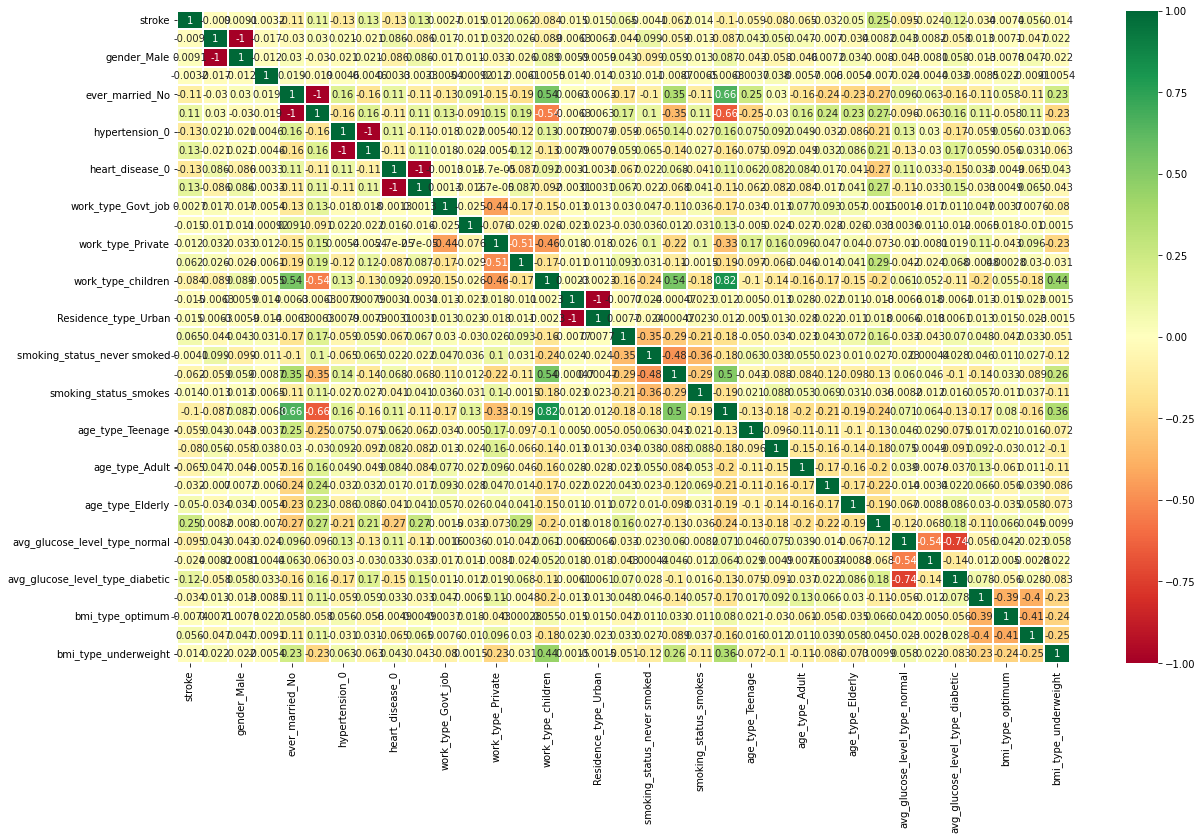

In [22]:
sns.heatmap(dummydf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Narysujemy pairplot

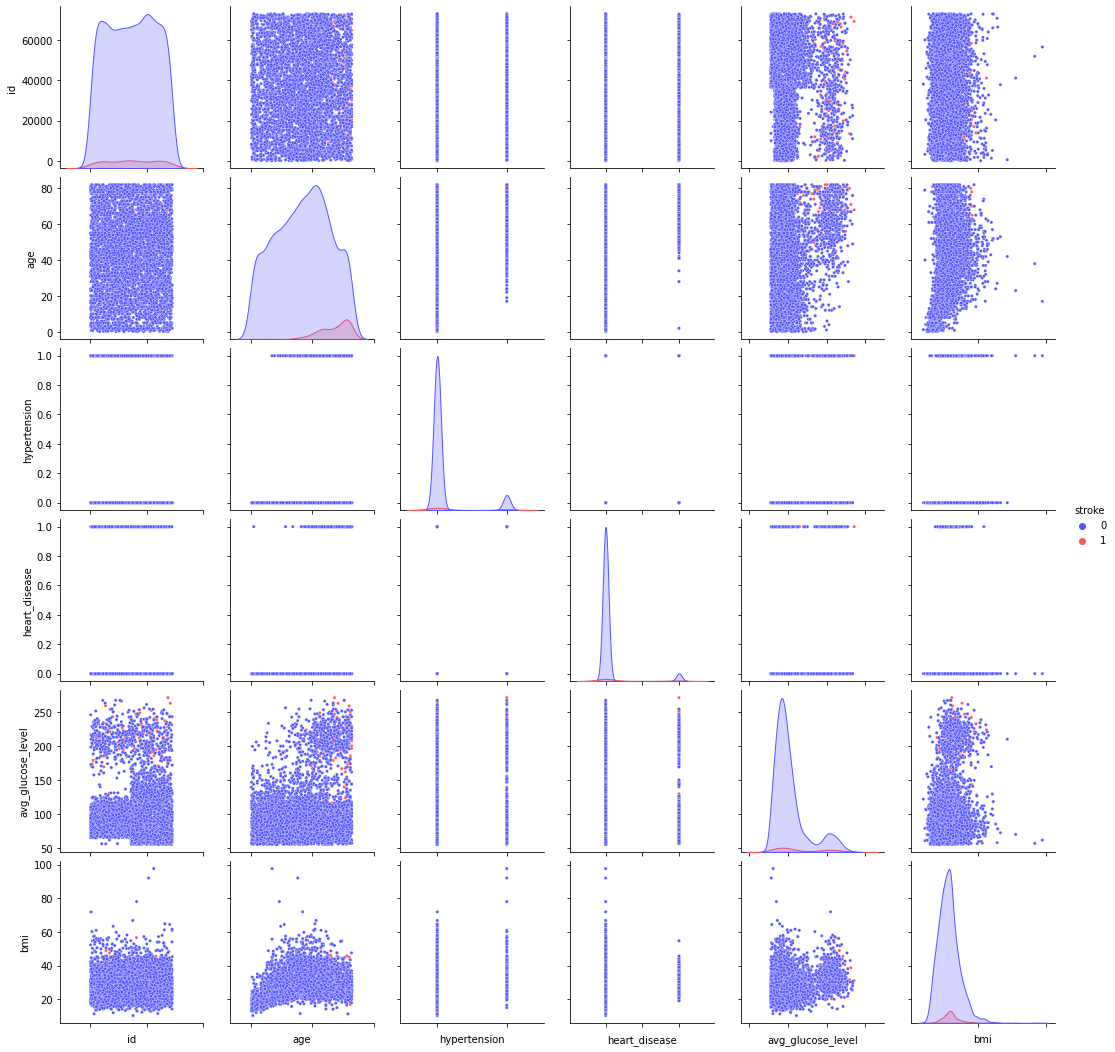

In [23]:
g = sns.pairplot(data=data, hue='stroke', palette = 'seismic',diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

Modelowanie

In [24]:
from sklearn.model_selection import train_test_split  # for split the data
from sklearn.metrics import accuracy_score, recall_score  #for accuracy_score
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import StratifiedKFold

In [25]:
all_features = dummydf.drop("stroke",axis=1)
all_features

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,work_type_Govt_job,...,age_type_Mature_adult,age_type_Elderly,age_type_Very_old,avg_glucose_level_type_normal,avg_glucose_level_type_pre_diabetic,avg_glucose_level_type_diabetic,bmi_type_obesity,bmi_type_optimum,bmi_type_overweight,bmi_type_underweight
0,0,1,0,0,1,1,0,0,1,0,...,0,0,1,0,0,1,1,0,0,0
1,1,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
2,0,1,0,0,1,1,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
3,1,0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
4,1,0,0,0,1,0,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0,0,1,0,1,1,0,0,...,0,0,1,1,0,0,0,0,1,0
5106,1,0,0,0,1,1,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
5107,1,0,0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5108,0,1,0,0,1,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0


In [26]:
target = dummydf['stroke']
X_train,X_test,y_train,y_test = train_test_split(all_features,target,test_size=0.3,random_state=42, stratify=target)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3577, 34), (1533, 34), (3577,), (1533,))

In [28]:
print(y_test[y_test==1].shape,
y_test[y_test==0].shape)

(75,) (1458,)


Możemy teraz podjąć się trenowania i przewidywania. Mamy wiele modeli do wyboru. Za pomocą techniki supervised learning wytrenujemy i ocenimy każdy model. Najlepsze z nich wybierzemy do gridowania.

In [29]:
names = ['Logistic Regression',
              'Random Forest', 'Support Vector Machines','KNN','Decision Tree', 'AdaBoostClassifier',
              'Gradient Decent','MLP']
crosval_scores = []
accuracy_scores = []
recall_scores = []
kfold = StratifiedKFold(shuffle=True,random_state=1234)

Logistic Regression

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 95.11
The cross validated score for Logistic Regression is: 95.13


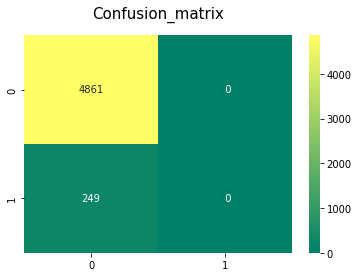

In [30]:
from sklearn.linear_model import LogisticRegression # Logistic Regression
model = LogisticRegression()
model.fit(X_train,y_train)
prediction_lr=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Logistic Regression is',round(accuracy_score(y_test,prediction_lr)*100,2))
result_lr=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Logistic Regression is:',round(result_lr.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_lr.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_lr)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_lr)*100,2))

Random Forest Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 94.0
The cross validated score for Random Forest Classifier is: 94.05


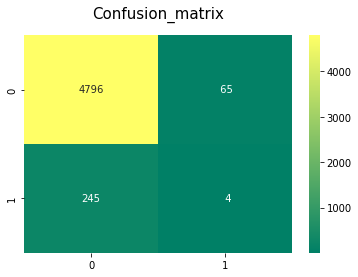

In [31]:
# kfold = StratifiedKFold(n_splits=10,random_state=8,shuffle=True)
# Random Forests
from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(criterion='gini', n_estimators=700,
#                              min_samples_split=10,min_samples_leaf=1,
#                              max_features='auto',oob_score=True,
#                              random_state=1,n_jobs=-1)
model = RandomForestClassifier(n_jobs=4)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(y_test,prediction_rm)*100,2))
result_rm=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_rm.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_rm)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_rm)*100,2))

Support Vector Machines

--------------The Accuracy of the model----------------------------
The accuracy of the Support Vector Machines Classifier is 95.11
The cross validated score for Support Vector Machines Classifier is: 95.13


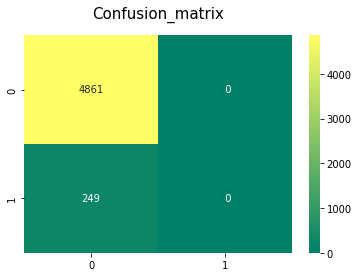

In [32]:
# kfold = StratifiedKFold(n_splits=10,random_state=15,shuffle=True)
# Support Vector Machines
from sklearn.svm import SVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Support Vector Machines Classifier is',round(accuracy_score(y_test,prediction_svm)*100,2))
result_svm=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Support Vector Machines Classifier is:',round(result_svm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_svm.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_svm)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_svm)*100,2))

KNN Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the K Nearst Neighbors Classifier is 94.59
The cross validated score for K Nearest Neighbors Classifier is: 94.97


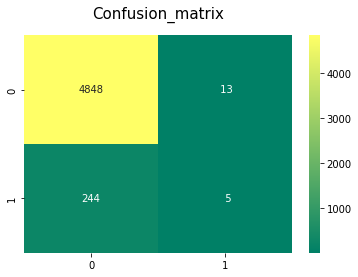

In [33]:
# kfold = StratifiedKFold(n_splits=10,random_state=39,shuffle=True)
##knn
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the K Nearst Neighbors Classifier is',round(accuracy_score(y_test,prediction_knn)*100,2))
result_knn=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_knn.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_knn)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_knn)*100,2))

Decision Tree Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the DecisionTree Classifier is 92.24
The cross validated score for Decision Tree classifier is: 92.23


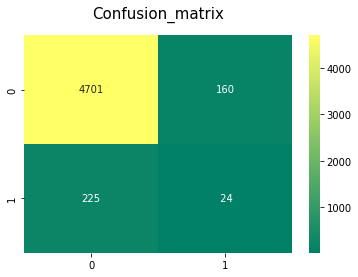

In [34]:
# kfold = StratifiedKFold(n_splits=10,random_state=587,shuffle=True)
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# model= DecisionTreeClassifier(criterion='gini',
#                              min_samples_split=10,min_samples_leaf=1,
#                              max_features='auto')
model= DecisionTreeClassifier()
model.fit(X_train,y_train)
prediction_tree=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the DecisionTree Classifier is',round(accuracy_score(y_test,prediction_tree)*100,2))
result_tree=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Decision Tree classifier is:',round(result_tree.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_tree.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_tree)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_tree)*100,2))

AdaBoost

--------------The Accuracy of the model----------------------------
The accuracy of the AdaBoostClassifier is 95.11
The cross validated score for AdaBoostClassifier is: 95.15


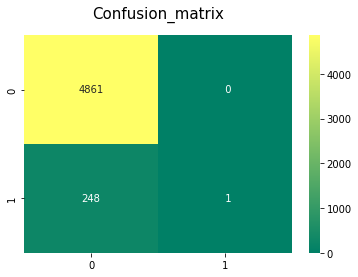

In [35]:
# kfold = StratifiedKFold(n_splits=10,random_state=6969,shuffle=True)
from sklearn.ensemble import AdaBoostClassifier
model= AdaBoostClassifier()
model.fit(X_train,y_train)
prediction_adb=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the AdaBoostClassifier is',round(accuracy_score(y_test,prediction_adb)*100,2))
result_adb=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_adb.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_adb.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_adb)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_adb)*100,2))

Gradient Boosting Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the Gradient Boosting Classifier is 95.24
The cross validated score for Gradient Boosting Classifier is: 94.99


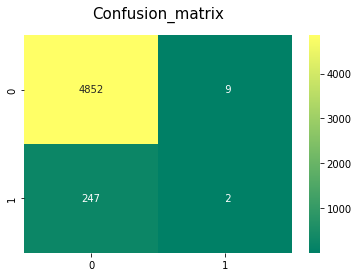

In [36]:
# kfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()

model.fit(X_train,y_train)
prediction_gbc=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Gradient Boosting Classifier is',round(accuracy_score(y_test,prediction_gbc)*100,2))
result_gbc=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Gradient Boosting Classifier is:',round(result_gbc.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_gbc.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_gbc)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_gbc)*100,2))

Wypróbujemy jeszcze model oparty o sieci neuronowe MLP Classifier

In [37]:
# kfold = StratifiedKFold(n_splits=10,random_state=1121315,shuffle=True)
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model.fit(X_train,y_train)
prediction_mlp = model.predict(X_test)

--------------The Accuracy of the model----------------------------
The accuracy of the MLP Classifier is 93.87
The cross validated score for MLP Classifier is: 94.48


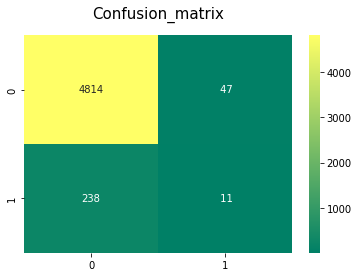

In [38]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the MLP Classifier is',round(accuracy_score(y_test,prediction_mlp)*100,2))
result_mlp=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for MLP Classifier is:',round(result_mlp.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_mlp.mean()*100,2))
accuracy_scores.append(round(accuracy_score(y_test,prediction_mlp)*100,2))
recall_scores.append(round(recall_score(y_test,prediction_mlp)*100,2))

In [39]:
models = pd.DataFrame({
    'Model':names, 'Crossval score accuracy': crosval_scores, 'Accuracy': accuracy_scores, 'Recall': recall_scores
})
models.sort_values(by='Crossval score accuracy', ascending=False)

,Model,Crossval score accuracy,Accuracy,Recall
5,AdaBoostClassifier,95.15,95.11,0.00
0,Logistic Regression,95.13,95.11,0.00
2,Support Vector Machines,95.13,95.11,0.00
6,Gradient Decent,94.99,95.24,2.67
3,KNN,94.97,94.59,5.33
7,MLP,94.48,93.87,4.00
1,Random Forest,94.05,94.00,2.67
4,Decision Tree,92.23,92.24,17.33


Z tabeli wybieramy najlepsze modele (na początku ze względu na accuracy)

Będziemy teraz tworzyć gridy dla najlepszych modeli. Będziemy rysować heatmapy, żeby upewnić się o poprawnym doborze parametrów

In [40]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

current_important_scoring = "accuracy"

Fitting 5 folds for each of 8 candidates, totalling 40 fits


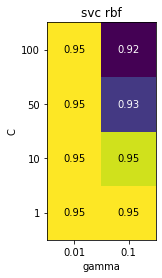

In [41]:
from sklearn.model_selection import GridSearchCV
# kfold = StratifiedKFold(n_splits=10,random_state=744255,shuffle=True)
# rbf
model= SVC()
param_grid_rbf = {'kernel': ['rbf'],
                  'gamma': [0.01, 0.1],
                  'C': [1, 10, 50, 100]}

modelsvm_rbf = GridSearchCV(model,param_grid = param_grid_rbf, cv=kfold, scoring=current_important_scoring, n_jobs= 4, verbose = 1)

modelsvm_rbf.fit(X_train,y_train)
X_prediction_svm_rbf = modelsvm_rbf.predict(X_test)
results = pd.DataFrame(modelsvm_rbf.cv_results_)
scores = np.array(results.mean_test_score).reshape(4,2)
heatmap(scores, xlabel='gamma', xticklabels=param_grid_rbf['gamma'], ylabel='C', yticklabels=param_grid_rbf['C'], cmap="viridis")
plt.title('svc rbf')
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


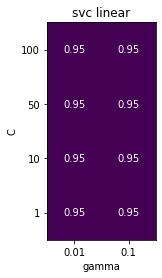

In [42]:
# linear
model= SVC()
param_grid_linear = {'kernel': ['linear'],
                  'gamma': [0.01, 0.1],
                  'C': [1, 10, 50, 100]}

modelsvm_linear = GridSearchCV(model,param_grid = param_grid_linear, cv=kfold, scoring=current_important_scoring, n_jobs= 4, verbose = 1)

modelsvm_linear.fit(X_train,y_train)
X_prediction_svm_linear = modelsvm_linear.predict(X_test)
results = pd.DataFrame(modelsvm_linear.cv_results_)
scores = np.array(results.mean_test_score).reshape(4,2)
heatmap(scores, xlabel='gamma', xticklabels=param_grid_linear['gamma'], ylabel='C', yticklabels=param_grid_linear['C'], cmap="viridis")
plt.title('svc linear')
plt.show()

In [43]:
model= SVC()
param_grid = {'kernel': ['rbf','linear'],
                  'gamma': [0.01, 0.1],
                  'C': [1, 10, 50, 100]}

modelsvm = GridSearchCV(model,param_grid = param_grid, cv=kfold, scoring=current_important_scoring, n_jobs= 4, verbose = 1)

modelsvm.fit(X_train,y_train)
X_prediction_svm = modelsvm.predict(X_test)
print(modelsvm.best_estimator_)

# Best score
print(modelsvm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=1, gamma=0.01)
0.9513560182833926


In [44]:
# kfold = StratifiedKFold(n_splits=10,random_state=98765,shuffle=True)
model = LogisticRegression()
param_grid = {'C':np.logspace(-4,4,10),'penalty':['l1','l2'],'solver':['liblinear']}
modellr = GridSearchCV(model,param_grid=param_grid,cv=kfold,scoring=current_important_scoring, n_jobs= 4, verbose = 1)
modellr.fit(X_train,y_train)
X_prediction_lr = modellr.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


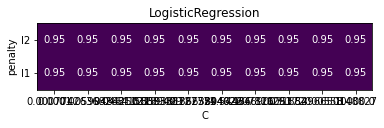

In [45]:
results = pd.DataFrame(modellr.cv_results_)
scores = np.array(results.mean_test_score).reshape(2,10)
heatmap(scores, xlabel='C', xticklabels=param_grid['C'], ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
plt.title('LogisticRegression')
plt.show()

In [46]:
print(modellr.best_estimator_)
print(modellr.best_score_)

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')
0.9513560182833926


In [47]:
# kfold = StratifiedKFold(n_splits=10,random_state=123456,shuffle=True)
model = AdaBoostClassifier()

param_grid = {
              'n_estimators' : [30,40,50,60,70,100],
              'learning_rate': [10**i for i in range(-4,4,1)]
}

modelabc = GridSearchCV(model, param_grid,scoring=current_important_scoring,n_jobs=4,cv=kfold)
modelabc.fit(X_train,y_train)
X_prediction_abc = modelabc.predict(X_test)

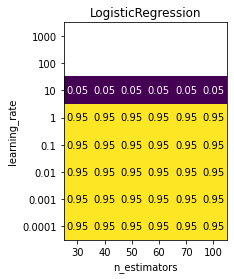

In [48]:
results = pd.DataFrame(modelabc.cv_results_)
scores = np.array(results.mean_test_score).reshape(8,6)
heatmap(scores, xlabel='n_estimators', xticklabels=param_grid['n_estimators'], ylabel='learning_rate', yticklabels=param_grid['learning_rate'], cmap="viridis")
plt.title('LogisticRegression')
plt.show()

In [49]:
print(modelabc.best_estimator_)
print(modelabc.best_score_)

AdaBoostClassifier(learning_rate=0.0001, n_estimators=30)
0.9513560182833926


Wypróbujmy jeszcze model oparty na sieci neuronowej MLP classifier

In [50]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

param_grid = {
            'hidden_layer_sizes': [(5,5),(5,6),(5,7)],
            'learning_rate_init': [0.0001,0.001, 0.01],
            'max_iter': [100],
            'batch_size': [8, 16,32,64],
}

modelmlp = GridSearchCV(model, param_grid,scoring=current_important_scoring,n_jobs=4,cv=kfold)
modelmlp.fit(X_train,y_train)
X_prediction_mlp = modelmlp.predict(X_test)

In [51]:
results = pd.DataFrame({'names': ['SVC linear', 'SVC rbf', 'Logistic Regression','AdaBoost','MLPClassifier'], 'accuracy':[accuracy_score(y_test,X_prediction_svm_linear),accuracy_score(y_test,X_prediction_svm_rbf),accuracy_score(y_test,X_prediction_lr),accuracy_score(y_test,X_prediction_abc),accuracy_score(y_test,X_prediction_mlp)]})
results.sort_values(by='accuracy',ascending=False)

,names,accuracy
0,SVC linear,0.951076
1,SVC rbf,0.951076
2,Logistic Regression,0.951076
3,AdaBoost,0.951076
4,MLPClassifier,0.951076


Przyjrzyjmy się jeszcze wynikom recall poszczególnych modeli. W zależności od zastosowania modelu, może nam zależeć np. na zapobieganiu przez przewidywanie zawału osób, które jeszcze na tego zawału nie odbyły. Wtedy będzie nam zależeć przede wszystkim na maksymalnej ilości TP i minimalnej ilości FN. Wyżej testowane modele słabo sobie radzą z takim zadaniem, spróbujmy jakkolwiek rokujące- Decision Tree i KNN.

In [52]:
current_important_scoring = "recall"

In [53]:
model = KNeighborsClassifier()
k_range = list(range(1,5))
param_grid = {'n_neighbors':k_range,'weights':['uniform','distance'],'leaf_size':[10,20,30,40,50]}

modelknn = GridSearchCV(model, param_grid, cv=kfold, scoring=current_important_scoring)
modelknn.fit(X_train,y_train)
X_prediction_knn = modelknn.predict(X_test)
knn_recall = recall_score(y_test,X_prediction_knn)
knn_recall

0.14666666666666667

In [54]:
model = DecisionTreeClassifier()
param_grid = { 'criterion':['gini','entropy','log_loss'],'max_depth': np.arange(0, 100,5),'min_samples_split': np.arange(1,6,1)}

modeltree = GridSearchCV(model, param_grid, cv=kfold, scoring=current_important_scoring)
modeltree.fit(X_train,y_train)
X_prediction_tree = modeltree.predict(X_test)
tree_recall = recall_score(y_test,X_prediction_tree)
tree_recall

0.12

In [55]:
results_recall = pd.DataFrame({'names': ['KNN','DecisionTreeClassifier'], 'recall':[knn_recall,tree_recall]})
results_recall.sort_values(by='recall',ascending=False)

,names,recall
0,KNN,0.146667
1,DecisionTreeClassifier,0.120000


Widzimy, że recall jest wyjątkowo niski. Dataset wydaje się słaby lub nieprzygotowany na realne standardy/ normy, które zastosowałem w pre- processingu. W rezultacie powyższe próby trenowania zwracają modele, które zwracają prawie zawsze zera. Nie udało się wyszkolić nic ponad 12% (15%) recall mimo wielu wstępnych prób, co może świadczyć o słabej jakości datasetu.

Spróbujmy ręcznie zaimplementować sieć neoronową. Być może taki model przyniesie lepsze wyniki.

In [43]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import relu
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras import initializers
model = Sequential()
initializer = initializers.RandomUniform(minval=0., maxval=1.)
# input layer
model.add(Dense(100, input_shape=(X_train.shape[1],), kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(100, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, kernel_initializer=initializer))
model.add(Activation('sigmoid'))

# optymalizator
sgd = SGD()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall','Accuracy'])

In [44]:
# fitting
hist = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=30, batch_size=16, verbose = 1)

Epoch 1/30
224/224 [==============================] - 2s 3ms/step - loss: 12.3366 - recall: 0.8218 - Accuracy: 0.2768 - val_loss: 138.8895 - val_recall: 1.0000 - val_Accuracy: 0.0509
Epoch 2/30
224/224 [==============================] - 0s 2ms/step - loss: 2.9427 - recall: 0.5690 - Accuracy: 0.6561 - val_loss: 0.7336 - val_recall: 0.3067 - val_Accuracy: 0.8565
Epoch 3/30
224/224 [==============================] - 0s 2ms/step - loss: 0.3835 - recall: 0.1034 - Accuracy: 0.9323 - val_loss: 0.2332 - val_recall: 0.0133 - val_Accuracy: 0.9491
Epoch 4/30
224/224 [==============================] - 0s 2ms/step - loss: 0.3213 - recall: 0.0172 - Accuracy: 0.9410 - val_loss: 0.2143 - val_recall: 0.0000e+00 - val_Accuracy: 0.9491
Epoch 5/30
224/224 [==============================] - 0s 2ms/step - loss: 0.2814 - recall: 0.0287 - Accuracy: 0.9441 - val_loss: 0.2053 - val_recall: 0.0000e+00 - val_Accuracy: 0.9511
Epoch 6/30
224/224 [==============================] - 0s 2ms/step - loss: 0.2482 - recall

[]

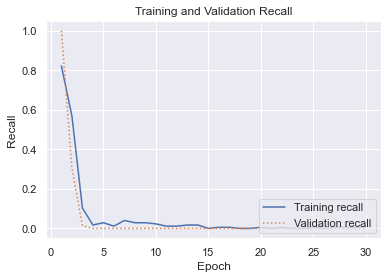

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

rec = hist.history['recall']
rec_val = hist.history['val_recall']

acc = hist.history['Accuracy']
acc_val = hist.history['val_Accuracy']
epochs = range(1, len(rec) + 1)

plt.plot(epochs, rec, '-', label='Training recall')
plt.plot(epochs, rec_val, ':', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.plot()

[]

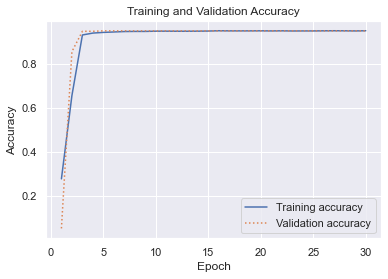

In [46]:
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, acc_val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Widzimy po raz kolejny, że otrzymujemy w konsekwencji klasyfikator zerowy.